In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

df_train = pd.read_csv("dataset ideology/politicES_phase_2_train_public.csv", on_bad_lines='skip')
df_test = pd.read_csv("dataset ideology/politicES_phase_2_test_codalab.csv", on_bad_lines='skip')

# Uno ambos dataset en uno solo
full_data = pd.concat([df_train, df_test])
full_data= full_data[:50000] #Probamos con 3000 por temas de computo

## Análisis del dataset

In [19]:
full_data.drop('label', axis=1, inplace=True)  #no se para que sirve label

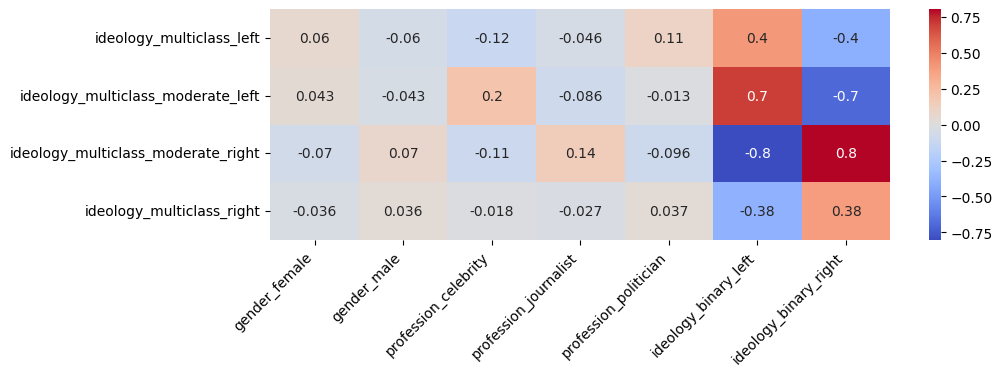

In [20]:
# Seleccionamos solo las columnas de interés para la correlación
columns_of_interest = ['gender', 'profession', 'ideology_binary', 'ideology_multiclass']

data_for_correlation = full_data[columns_of_interest]
data_dummies = pd.get_dummies(data_for_correlation, prefix=None)

correlation_matrix = data_dummies.corr()

correlations_with_ideology_multiclass = correlation_matrix.filter(regex='ideology_multiclass').drop(
    data_dummies.filter(regex='ideology_multiclass').columns, axis=0)

plt.figure(figsize=(10, 3))  # Ajusta el tamaño de la figura según sea necesario
sns.heatmap(correlations_with_ideology_multiclass.T, annot=True, cmap='coolwarm')
plt.xticks(rotation=45, ha='right')
plt.show()

Vemos que 
todas las columnas tienen algo de correlacion con la ideología. 

Dividimos el dataset completo con las siguientes proporciones:

- train: 70% 
- test: 20%
- validation: 10%

In [21]:
train_data, test_data = train_test_split(full_data, test_size=0.3, stratify=full_data['ideology_multiclass'], random_state=42)
test_data, valid_data = train_test_split(test_data, test_size=1/3, stratify=test_data['ideology_multiclass'], random_state=42)   #OJO el stratify

In [22]:
y_train= train_data['ideology_multiclass']
y_test= test_data['ideology_multiclass']
y_val = valid_data['ideology_multiclass']

In [23]:
counts_train = y_train.value_counts().to_dict()
print("Distribución en training:", counts_train)
counts_val = y_val.value_counts().to_dict()
print("Distribución en validacion:", counts_val)
counts_test = y_test.value_counts().to_dict()
print("Distribución en test:", counts_test)

Distribución en training: {'moderate_left': 13664, 'moderate_right': 11648, 'left': 6104, 'right': 3584}
Distribución en validacion: {'moderate_left': 1952, 'moderate_right': 1664, 'left': 872, 'right': 512}
Distribución en test: {'moderate_left': 3904, 'moderate_right': 3328, 'left': 1744, 'right': 1024}


Text(0, 0.5, 'Número de Instancias')

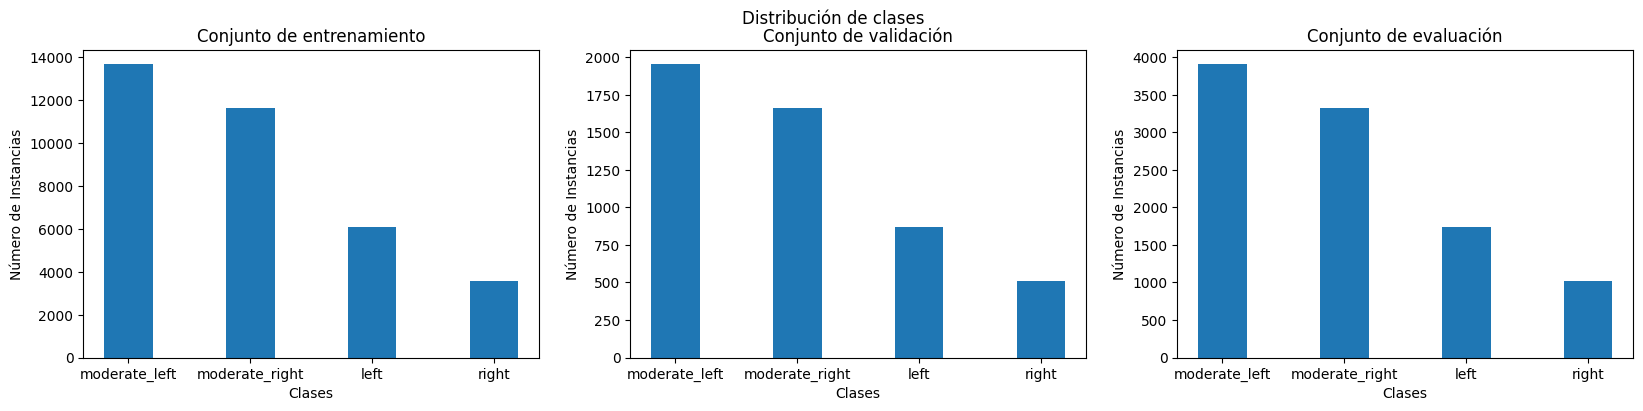

In [24]:
LABELS=counts_train.keys()

fig, (ax_train, ax_val, ax_test) = plt.subplots(1, 3, figsize=(20, 4))
fig.suptitle('Distribución de clases')
ax_train.bar(LABELS, counts_train.values(), width=0.4)
ax_train.set_title('Conjunto de entrenamiento')
ax_train.set_xlabel('Clases')
ax_train.set_ylabel('Número de Instancias')

ax_val.bar(LABELS, counts_val.values(), width=0.4)
ax_val.set_title('Conjunto de validación')
ax_val.set_xlabel('Clases')
ax_val.set_ylabel('Número de Instancias')


ax_test.bar(LABELS, counts_test.values(), width=0.4)
ax_test.set_title('Conjunto de evaluación')
ax_test.set_xlabel('Clases')
ax_test.set_ylabel('Número de Instancias')
     

Claramente se aprecia como los 3 conjuntos mantienen la proporcion 

Veamos a comprobar la longitud de los textos

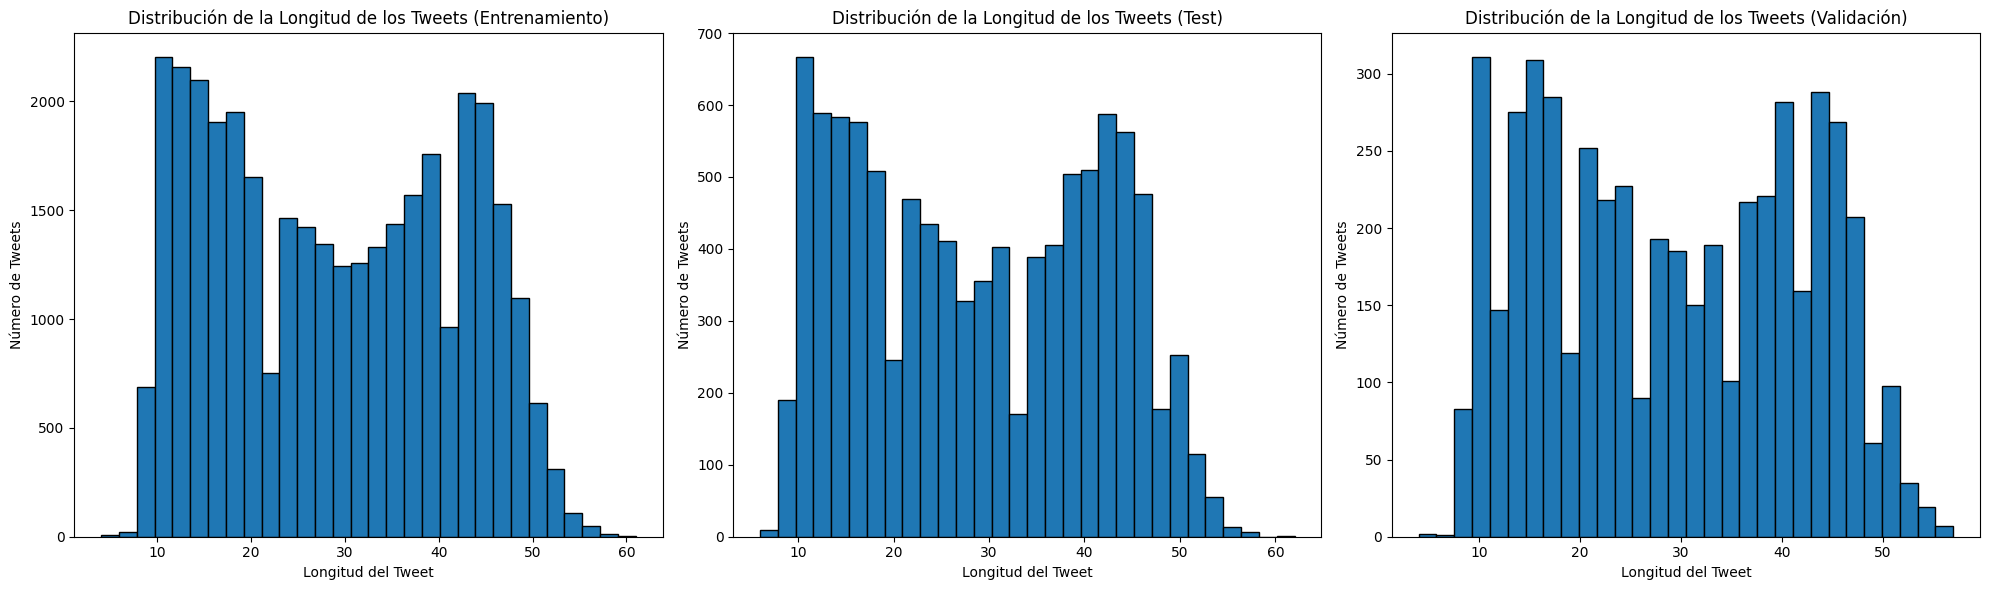

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(20,6)) 

# Gráfica para train_data
axes[0].hist(train_data['tweet'].apply(lambda text: len(text.split())), bins=30, edgecolor='black')
axes[0].set_title('Distribución de la Longitud de los Tweets (Entrenamiento)')
axes[0].set_xlabel('Longitud del Tweet')
axes[0].set_ylabel('Número de Tweets')

# Gráfica para valid_data
axes[2].hist(valid_data['tweet'].apply(lambda text: len(text.split())), bins=30, edgecolor='black')
axes[2].set_title('Distribución de la Longitud de los Tweets (Validación)')
axes[2].set_xlabel('Longitud del Tweet')
axes[2].set_ylabel('Número de Tweets')

# Gráfica para test_data
axes[1].hist(test_data['tweet'].apply(lambda text: len(text.split())), bins=30, edgecolor='black')
axes[1].set_title('Distribución de la Longitud de los Tweets (Test)')
axes[1].set_xlabel('Longitud del Tweet')
axes[1].set_ylabel('Número de Tweets')

plt.tight_layout()
plt.show()

Por lo general los textos tienen la misma longitud. Es cierto que hay algunas longitudes inusualmente bajas, posiblemente por haber reducido el dataset

## Preprocesamiento de texto

In [26]:
import spacy
import re

# Cargar el modelo en español
nlp = spacy.load('es_core_news_sm')

# Lista de emojis y su significado 
emojis = {':)': 'emoción positiva', ':(': 'emoción negativa'}

def preprocess_text(tweet):
    tweet = re.sub(r'https?://\S+', '', tweet)
    # Traducir emojis a texto
    for emoji, description in emojis.items():
        tweet = tweet.replace(emoji, f' {description} ')
    # Procesar el tweet con spaCy
    doc = nlp(tweet)
    # Conservar palabras como lemas, excluyendo stopwords y puntuación
    # Mantener hashtags y menciones intactas
    tokens = [token.lemma_ if not token.is_punct and not token.like_url and token.text not in nlp.Defaults.stop_words else token.text
              for token in doc if not token.is_space and '#' not in token.text and '@' not in token.text]
    return ' '.join(tokens)


In [27]:
full_data['clean_tweet'] = full_data['tweet'].apply(preprocess_text)

falta deteccion de n_gramas

##  Clasificador

In [28]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, generation, DataCollatorWithPadding, TrainingArguments, Trainer, EarlyStoppingCallback
import torch
import tensorflow as tf
from datasets import Dataset

model_name = 'AIDA-UPM/BERTuit-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=4, from_tf=True)


All TF 2.0 model weights were used when initializing RobertaForSequenceClassification.

All the weights of RobertaForSequenceClassification were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use RobertaForSequenceClassification for predictions without further training.


In [29]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

full_data['ideology_multiclass'] = label_encoder.fit_transform(full_data['ideology_multiclass'])

In [30]:
# Función para tokenizar el dataset
def tokenize_function(example):
    return tokenizer(example['clean_tweet'], truncation=True)

# Conversión del DataFrame de pandas a un Dataset de Hugging Face para pasarlo al modelo
huggingface_dataset = Dataset.from_pandas(full_data)
huggingface_dataset

Dataset({
    features: ['gender', 'profession', 'ideology_binary', 'ideology_multiclass', 'tweet', 'clean_tweet', '__index_level_0__'],
    num_rows: 50000
})

In [31]:
# Aplicamos la tokenización a todo el dataset
tokenized_dataset = huggingface_dataset.map(tokenize_function, batched=True)
tokenized_dataset

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map: 100%|██████████| 50000/50000 [00:01<00:00, 32374.11 examples/s]


Dataset({
    features: ['gender', 'profession', 'ideology_binary', 'ideology_multiclass', 'tweet', 'clean_tweet', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 50000
})

In [32]:
tokenized_dataset = tokenized_dataset.rename_column("ideology_multiclass", "labels") 
tokenized_dataset = tokenized_dataset.remove_columns(["gender","profession","ideology_binary","tweet","clean_tweet", "__index_level_0__"])  # Nos quedamos solo con los valores que necesita el modelo
tokenized_dataset

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 50000
})

In [33]:
from datasets import DatasetDict

# Dividimos los datos en entrenamiento y validación. Dejamos un 30% del dataset para validación y test
train_test_split = tokenized_dataset.train_test_split(test_size=0.3)
test_valid_split = train_test_split['test'].train_test_split(test_size=0.66) # Dividimos entre conjunto de validación y test

# Creamos un DatasetDict para organizar los subconjuntos
final_datasets = DatasetDict({
    'train': train_test_split['train'],
    'validation': test_valid_split['train'],  # La parte de 'test' que se usará para validación
    'test': test_valid_split['test']          # La parte de 'test' que se usará para pruebas
})

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)  # Introducimos el data collator para trabajar con padding dinámico


In [34]:

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt


# Definimos la función encargada de evaluar las métricas en el entrenamiento
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    acc = accuracy_score(labels, predictions)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}



# Definimos los argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=6,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    evaluation_strategy="epoch",
    save_strategy='epoch',
    logging_strategy='epoch',
    logging_dir='./logs',
    load_best_model_at_end=True,
    seed=42,
)

# Inicializamos el Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=final_datasets['train'],
    eval_dataset=final_datasets['validation'],
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    tokenizer=tokenizer,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.0)]
)

# Entrenamiento y evaluación
trainer.train()
training_stats = trainer.state.log_history

# Representación de las pérdidas a lo largo de las épocas
training_loss = [e['loss'] for e in training_stats if 'loss' in e]
validation_loss = [e['eval_loss'] for e in training_stats if 'eval_loss' in e]

plt.figure(figsize=(10, 6))
plt.plot(training_loss, label='Training loss')
plt.plot(validation_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Imprimimos las métricas del conjunto de test
test_results = trainer.evaluate(eval_dataset=final_datasets['test'])
print("Resultados en el conjunto de prueba:", test_results)


 17%|█▋        | 2188/13128 [1:16:54<6:26:50,  2.12s/it]

{'loss': 1.1361, 'learning_rate': 1.6666666666666667e-05, 'epoch': 1.0}



 17%|█▋        | 2188/13128 [1:19:34<6:26:50,  2.12s/it]

{'eval_loss': 1.020424723625183, 'eval_accuracy': 0.5596078431372549, 'eval_f1': 0.5469904580302447, 'eval_precision': 0.563621718654723, 'eval_recall': 0.5596078431372549, 'eval_runtime': 160.693, 'eval_samples_per_second': 31.738, 'eval_steps_per_second': 1.985, 'epoch': 1.0}


 33%|███▎      | 4376/13128 [2:32:11<4:21:30,  1.79s/it]  

{'loss': 0.8914, 'learning_rate': 1.3333333333333333e-05, 'epoch': 2.0}


KeyboardInterrupt: 